### Network-Based Recommendation: Workflow

- Load train/test edge subsets

- Construct bipartite train graph (positive edges only)

- Compute link prediction features for train/test

- Train supervised link prediction model

- Predict test edge probabilities & generate rankings

- Export results for evaluation and comparison

In [21]:
# Step 1: Load the sampled train/test datasets
# -------------------------------------------
# This notebook implements the network-based recommendation algorithm.
# We start by loading the train and test edge subsets generated earlier.

import pandas as pd

# Load the datasets
train = pd.read_csv("train_edges_sampled.csv")
test = pd.read_csv("test_edges_sampled.csv")

# Basic checks
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Show the first few rows for verification
display(train.head())
display(test.head())

Train shape: (208955, 18)
Test shape: (52240, 18)


,user_id,app_id,is_recommended,hours,helpful,funny,date,title,date_release,rating,positive_ratio,user_reviews,price_final,discount,win,mac,linux,steam_deck
0,9541860,377160,1,119.8,0,0,2022-05-04,Fallout 4,2015-11-09,Very Positive,83,205094,20.00,0.0,True,False,False,True
1,6987567,1245620,1,222.8,0,0,2022-02-25,ELDEN RING,2022-02-24,Very Positive,92,528702,60.00,0.0,True,False,False,True
2,6611257,346110,1,1.4,0,0,2015-10-29,ARK: Survival Evolved,2017-08-27,Very Positive,83,495087,15.00,0.0,True,True,False,True
3,614588,1063730,1,363.2,0,0,2021-10-11,New World,2021-09-28,Mostly Positive,70,222345,40.00,0.0,True,False,False,True
4,13537711,307690,1,26.0,0,0,2019-04-05,Sleeping Dogs: Definitive Edition,2014-10-08,Very Positive,92,45096,19.99,0.0,True,True,False,True


,user_id,app_id,is_recommended,hours,helpful,funny,date,title,date_release,rating,positive_ratio,user_reviews,price_final,discount,win,mac,linux,steam_deck
0,8724507,1599340,1,346.4,0,0,2022-02-19,Lost Ark,2022-02-11,Mostly Positive,71,194889,0.00,0.0,True,False,False,True
1,10979398,225540,1,14.3,0,0,2021-11-19,Just Cause™ 3,2015-11-30,Very Positive,83,88730,19.99,0.0,True,False,False,True
2,5180823,433340,1,80.1,0,0,2019-11-26,Slime Rancher,2017-08-01,Overwhelmingly Positive,97,97997,5.00,0.0,True,True,True,True
3,7626630,611500,1,4.6,0,0,2018-10-13,Quake Champions,2022-08-18,Mostly Positive,73,36191,0.00,0.0,True,False,False,True
4,7905867,250760,1,57.6,9,0,2020-11-28,Shovel Knight: Treasure Trove,2014-06-26,Overwhelmingly Positive,95,12466,39.99,0.0,True,True,True,True


In [22]:
# Step 2: Build the bipartite user–game train graph
# --------------------------------------------------
# We construct a bipartite graph using ONLY positive edges (is_recommended = 1).
# Negative edges should NOT be added to the graph, because link prediction
# features like Jaccard and Adamic–Adar rely on positive connections.

import networkx as nx

# Create an empty graph
G = nx.Graph()

# Filter positive training edges only
train_pos = train[train.is_recommended == 1]

# Add edges to the bipartite graph
# Users will be assigned bipartite attribute 0, games 1
for row in train_pos.itertuples():
    user = f"u_{row.user_id}"    # prefix helps avoid ID collisions
    game = f"g_{row.app_id}"
    
    # Add nodes with bipartite sets
    G.add_node(user, bipartite=0)
    G.add_node(game, bipartite=1)
    
    # Add edge (user, game)
    G.add_edge(user, game)

# Basic graph statistics
num_users = sum(1 for n,d in G.nodes(data=True) if d["bipartite"] == 0)
num_games = sum(1 for n,d in G.nodes(data=True) if d["bipartite"] == 1)
num_edges = G.number_of_edges()

print("Number of users:", num_users)
print("Number of games:", num_games)
print("Number of edges:", num_edges)


Number of users: 10638
Number of games: 1149
Number of edges: 177799


In [42]:
# Step 3A (Updated): Build train/test pairs including hours + helpful
# ------------------------------------------------------------------
# In this step, we construct the list of pairs used for feature extraction.
# Each pair contains:
#   (user_node, game_node, hours_played, helpful_votes)
# and the corresponding binary label (is_recommended).

train_pairs = []
train_labels = []

for _, row in train.iterrows():
    user_node = f"u_{int(row.user_id)}"
    game_node = f"g_{int(row.app_id)}"
    
    hours = float(row.hours)
    helpful = int(row.helpful)
    
    train_pairs.append((user_node, game_node, hours, helpful))
    train_labels.append(int(row.is_recommended))

print("Train pairs built:", len(train_pairs))


test_pairs = []
test_labels = []

for _, row in test.iterrows():
    user_node = f"u_{int(row.user_id)}"
    game_node = f"g_{int(row.app_id)}"
    
    hours = float(row.hours)
    helpful = int(row.helpful)
    
    test_pairs.append((user_node, game_node, hours, helpful))
    test_labels.append(int(row.is_recommended))

print("Test pairs built:", len(test_pairs))


# ---- Show 3 sample items ----
print("\nSample 3 train pairs:")
for i in range(3):
    print(train_pairs[i], " label:", train_labels[i])

print("\nSample 3 test pairs:")
for i in range(3):
    print(test_pairs[i], " label:", test_labels[i])
    


Train pairs built: 208955
Test pairs built: 52240

Sample 3 train pairs:
('u_9541860', 'g_377160', 119.8, 0)  label: 1
('u_6987567', 'g_1245620', 222.8, 0)  label: 1
('u_6611257', 'g_346110', 1.4, 0)  label: 1

Sample 3 test pairs:
('u_8724507', 'g_1599340', 346.4, 0)  label: 1
('u_10979398', 'g_225540', 14.3, 0)  label: 1
('u_5180823', 'g_433340', 80.1, 0)  label: 1


In [43]:
# Step 3B (Updated): Feature extraction with degree-based features + hours/helpful
# --------------------------------------------------------------------------------
# This function takes:
#   - the graph G
#   - a user_node (e.g., "u_12345")
#   - a game_node (e.g., "g_67890")
#   - hours (float)
#   - helpful (int)
#
# It returns a feature vector of length 10:
#   1. user_degree
#   2. game_degree
#   3. preferential_attachment
#   4. degree_sum
#   5. degree_diff
#   6. degree_ratio
#   7. log_user_degree
#   8. log_game_degree
#   9. hours
#   10. helpful


import numpy as np

def compute_features(G, user_node, game_node, hours, helpful):
    """
    Extract structural + behavioral features for a (user, game) pair.
    Structural features come from the bipartite graph G,
    and behavioral features (hours, helpful) come directly from the original dataset.
    """

    # --- 1. Node degrees ---
    # If node is not in the graph, treat its degree as zero
    deg_u = G.degree(user_node) if user_node in G else 0
    deg_g = G.degree(game_node) if game_node in G else 0

    # --- 2. Preferential attachment ---
    # Common link prediction heuristic: deg(user) * deg(game)
    pref_attach = deg_u * deg_g

    # --- 3. Simple degree combinations ---
    degree_sum = deg_u + deg_g
    degree_diff = abs(deg_u - deg_g)
    degree_ratio = deg_u / (deg_g + 1e-6)    # avoid division by zero

    # --- 4. Log-scaled degrees (for stability) ---
    log_deg_u = np.log1p(deg_u)
    log_deg_g = np.log1p(deg_g)

    # --- 5. Append behavioral features: hours + helpful ---
    # hours = total hours the user played the game
    # helpful = number of helpful votes received by the review
    feat_vec = [
        deg_u,
        deg_g,
        pref_attach,
        degree_sum,
        degree_diff,
        degree_ratio,
        log_deg_u,
        log_deg_g,
        hours,
        helpful
    ]

    return feat_vec




In [44]:
# Step 3C (Updated): Build the training feature matrix (X_train)
# ------------------------------------------------------------------
# For each (user_node, game_node, hours, helpful) pair in train_pairs,
# we compute the 10-dimensional feature vector defined in Step 3B.
#
# Output:
#   X_train: numpy array of shape (num_train_samples, 10)
#   y_train: list of labels (0/1)


X_train = []

for (user_node, game_node, hours, helpful) in train_pairs:
    feat_vec = compute_features(G, user_node, game_node, hours, helpful)
    X_train.append(feat_vec)

X_train = np.array(X_train)
y_train = np.array(train_labels)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nExample training feature row:")
print(X_train[0])


X_train shape: (208955, 10)
y_train shape: (208955,)

Example training feature row:
[1.30000000e+01 7.98000000e+02 1.03740000e+04 8.11000000e+02
 7.85000000e+02 1.62907268e-02 2.63905733e+00 6.68336095e+00
 1.19800000e+02 0.00000000e+00]


In [45]:
# Step 3D (Updated): Build the test feature matrix (X_test)
# ------------------------------------------------------------------
# For each (user_node, game_node, hours, helpful) pair in test_pairs,
# compute the same 10-dimensional feature vector used for training.

X_test = []

for (user_node, game_node, hours, helpful) in test_pairs:
    feat_vec = compute_features(G, user_node, game_node, hours, helpful)
    X_test.append(feat_vec)

X_test = np.array(X_test)
y_test = np.array(test_labels)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("\nExample test feature row:")
print(X_test[0])


X_test shape: (52240, 10)
y_test shape: (52240,)

Example test feature row:
[1.90000000e+01 2.32000000e+02 4.40800000e+03 2.51000000e+02
 2.13000000e+02 8.18965514e-02 2.99573227e+00 5.45103845e+00
 3.46400000e+02 0.00000000e+00]


In [ ]:
# Step 4A: Standardize the feature matrices (X_train and X_test)
# ----------------------------------------------------------------------
# We scale all 10 features using StandardScaler.
# This ensures:
#   - Each feature has mean = 0 and std = 1
#   - Necessary for Logistic Regression to behave well
#   - Prevents large-magnitude features (e.g., hours) from dominating the model

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("\nExample standardized training row:")
print(X_train_scaled[0])


Standardization complete.
X_train_scaled shape: (208955, 10)
X_test_scaled shape: (52240, 10)

Example standardized training row:
[-0.55866474  2.48710708  0.46589294  2.42768167  2.52995494 -0.6449116
 -0.60424737  1.73189982  0.37864597 -0.10441998]


In [47]:
# Step 4B: Train Logistic Regression on the standardized feature matrices
# ----------------------------------------------------------------------
# We use Logistic Regression to model the probability that a user recommends a game.
# The model now uses 10 features (8 structural + hours + helpful).

from sklearn.linear_model import LogisticRegression

# Create the model
model = LogisticRegression(
    solver="liblinear",    # stable for binary classification
    max_iter=3000          # ensure convergence
)

# Train the model
model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully.\n")

# Display learned coefficients
feature_names = [
    "user_degree",
    "game_degree",
    "pref_attach",
    "degree_sum",
    "degree_diff",
    "degree_ratio",
    "log_user_degree",
    "log_game_degree",
    "hours",
    "helpful"
]

print("Logistic Regression Coefficients:")
for name, coef in zip(feature_names, model.coef_[0]):
    print(f"{name:20s} {coef:.6f}")


Logistic Regression model trained successfully.

Logistic Regression Coefficients:
user_degree          0.372537
game_degree          -2.314362
pref_attach          -0.120524
degree_sum           -2.273621
degree_diff          4.696575
degree_ratio         -0.469051
log_user_degree      0.985224
log_game_degree      0.003712
hours                0.115819
helpful              -0.036949


In [48]:
# Step 4C: Predict probabilities on the test set and save results
# ----------------------------------------------------------------------
# We compute y_pred_prob = P(is_recommended = 1) for every (user, game) pair
# in the test set. Then we save a clean CSV file for evaluation.

# Predict probability that the review is positive (class 1)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Build output DataFrame
results = pd.DataFrame({
    "user_id": [int(p[0].replace("u_", "")) for p in test_pairs],
    "app_id":  [int(p[1].replace("g_", "")) for p in test_pairs],
    "hours":   [p[2] for p in test_pairs],
    "helpful": [p[3] for p in test_pairs],
    "y_true":  y_test,
    "y_pred_prob": y_pred_prob
})

# Save results to CSV
output_filename = "network_predictions_v2.csv"
results.to_csv(output_filename, index=False)

print(f"Test predictions saved to {output_filename}")
results.head()


Test predictions saved to network_predictions_v2.csv


,user_id,app_id,hours,helpful,y_true,y_pred_prob
0,8724507,1599340,346.4,0,1,0.909337
1,10979398,225540,14.3,0,1,0.906578
2,5180823,433340,80.1,0,1,0.901508
3,7626630,611500,4.6,0,1,0.793992
4,7905867,250760,57.6,9,1,0.847711


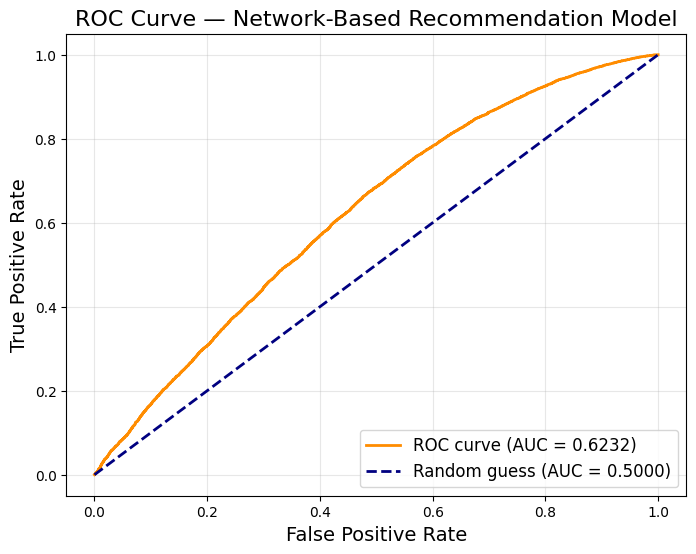

In [50]:
# Visualization: ROC Curve and AUC for the network-based recommendation model
# ---------------------------------------------------------------------------

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_test: true labels (0/1)
# y_pred_prob: predicted probabilities from Step 4C

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.4f})")

# Random guess baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Random guess (AUC = 0.5000)")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve — Network-Based Recommendation Model", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()


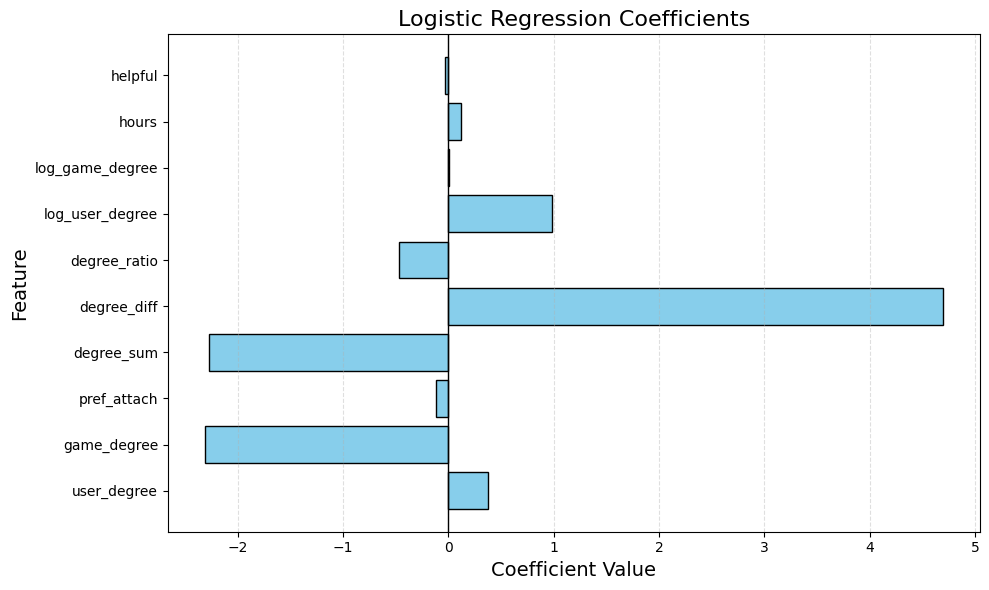

In [51]:
# Visualization 1: Logistic Regression Coefficient Bar Plot
# ---------------------------------------------------------
# Shows the relative importance and direction of all 10 features.
import matplotlib.pyplot as plt
import numpy as np

# Model coefficients correspond to features in this exact order:
feature_names = [
    "user_degree",
    "game_degree",
    "pref_attach",
    "degree_sum",
    "degree_diff",
    "degree_ratio",
    "log_user_degree",
    "log_game_degree",
    "hours",
    "helpful"
]

coeffs = model.coef_[0]

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names, coeffs, color="skyblue", edgecolor="black")
plt.title("Logistic Regression Coefficients", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.4)

# Draw vertical line at zero to show positive/negative
plt.axvline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()


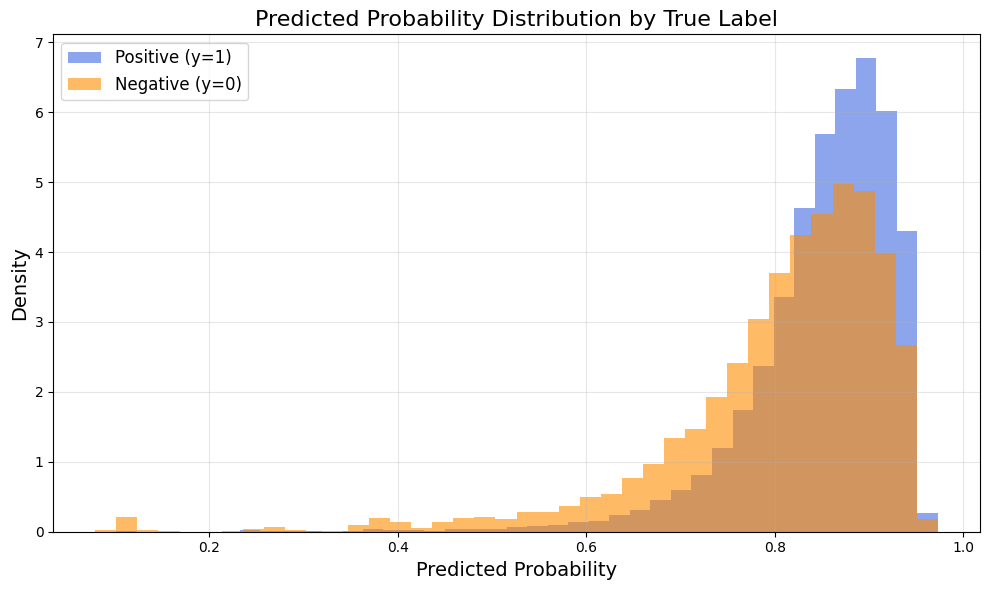

In [52]:
# Visualization 2: Positive vs Negative Predicted Probability Distribution
# -------------------------------------------------------------------------
# Helps evaluate whether the model assigns higher probability to positive edges.

import matplotlib.pyplot as plt

pos_probs = results[results.y_true == 1].y_pred_prob
neg_probs = results[results.y_true == 0].y_pred_prob

plt.figure(figsize=(10, 6))

plt.hist(pos_probs, bins=40, alpha=0.6, density=True,
         label="Positive (y=1)", color="royalblue")
plt.hist(neg_probs, bins=40, alpha=0.6, density=True,
         label="Negative (y=0)", color="darkorange")

plt.title("Predicted Probability Distribution by True Label", fontsize=16)
plt.xlabel("Predicted Probability", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


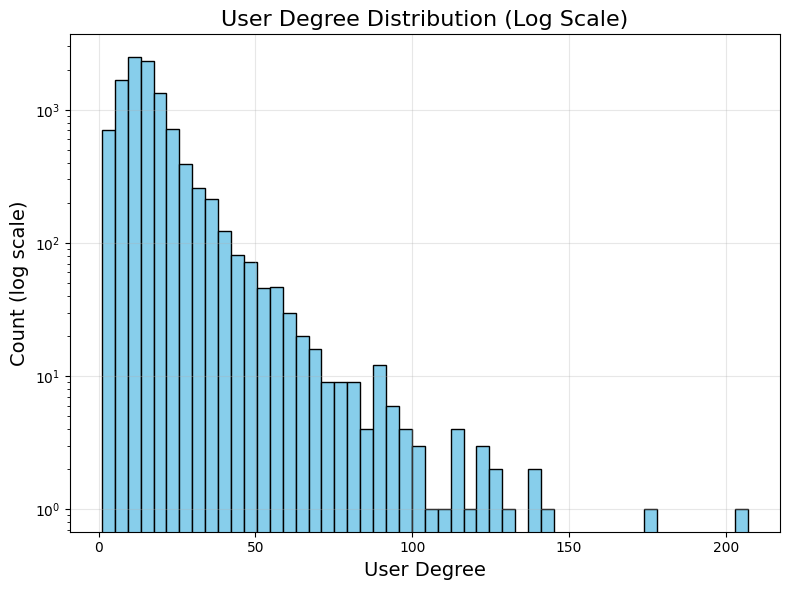

In [53]:
# Visualization 3: User Degree Distribution (log-scale)
# ------------------------------------------------------
# Shows the heavy-tailed activity distribution of users in the bipartite graph.

import matplotlib.pyplot as plt

# Extract degree for all user nodes
user_degrees = [
    G.degree(n) for n in G.nodes() if str(n).startswith("u_")
]

plt.figure(figsize=(8, 6))
plt.hist(user_degrees, bins=50, color="skyblue", edgecolor="black")
plt.yscale("log")     # long-tail distribution visualization

plt.title("User Degree Distribution (Log Scale)", fontsize=16)
plt.xlabel("User Degree", fontsize=14)
plt.ylabel("Count (log scale)", fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


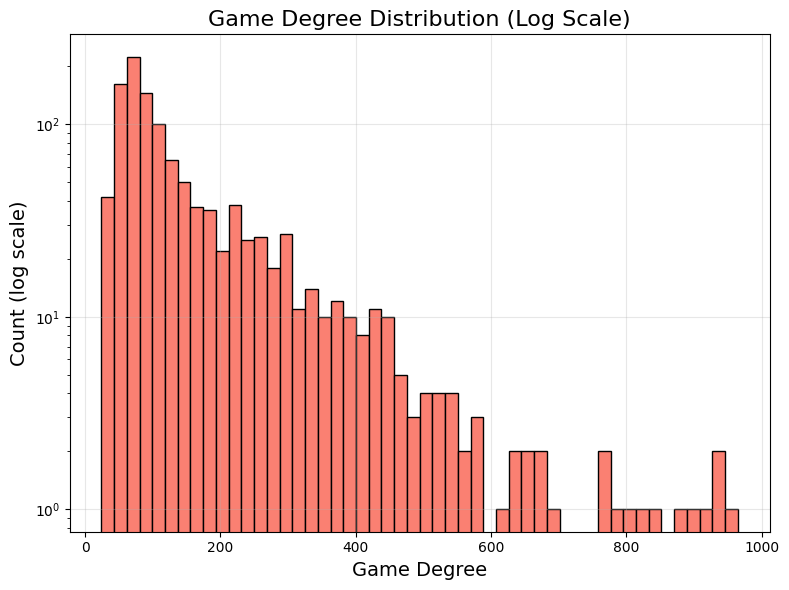

In [55]:
# Visualization 4: Game Degree Distribution (log-scale)
# ------------------------------------------------------
# Shows popularity concentration among games (another long-tail pattern).

game_degrees = [
    G.degree(n) for n in G.nodes() if str(n).startswith("g_")
]

plt.figure(figsize=(8, 6))
plt.hist(game_degrees, bins=50, color="salmon", edgecolor="black")
plt.yscale("log")

plt.title("Game Degree Distribution (Log Scale)", fontsize=16)
plt.xlabel("Game Degree", fontsize=14)
plt.ylabel("Count (log scale)", fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


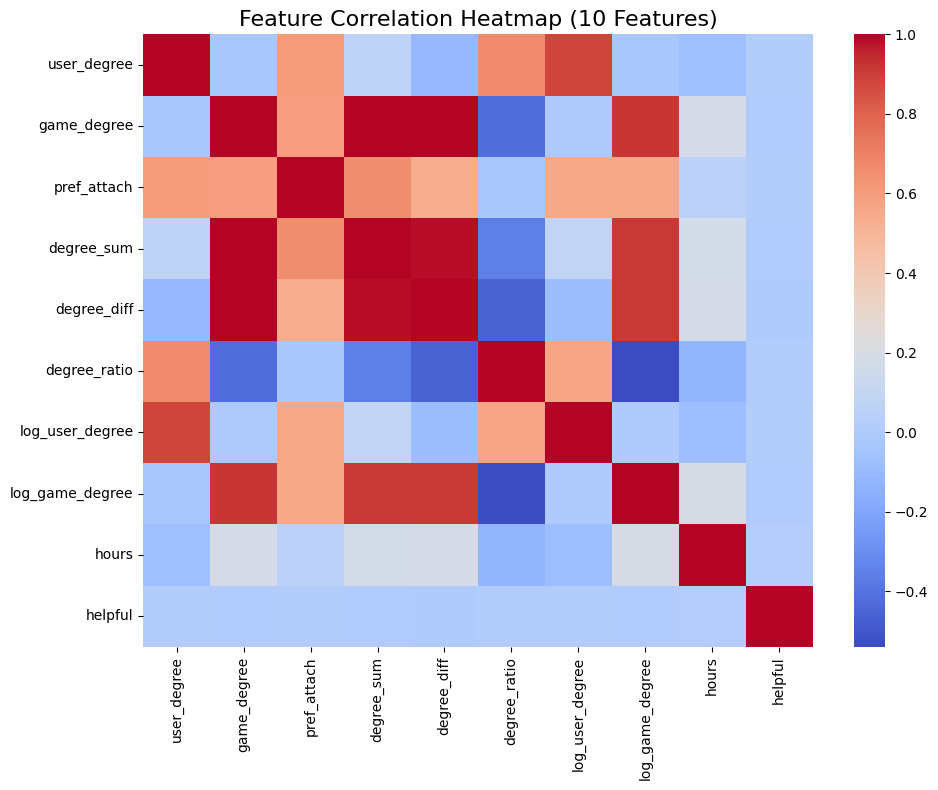

In [54]:
# Visualization 5: Feature Correlation Heatmap
# ---------------------------------------------
# Shows correlations among all 10 final features.

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Wrap X_train into a DataFrame for correlation computation
df_features = pd.DataFrame(X_train, columns=[
    "user_degree",
    "game_degree",
    "pref_attach",
    "degree_sum",
    "degree_diff",
    "degree_ratio",
    "log_user_degree",
    "log_game_degree",
    "hours",
    "helpful"
])

# Compute correlation matrix
corr_matrix = df_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm",
            xticklabels=True, yticklabels=True)

plt.title("Feature Correlation Heatmap (10 Features)", fontsize=16)
plt.tight_layout()
plt.show()
